In [1]:
from dotenv import dotenv_values
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q
import rasterio
import matplotlib.pyplot as plt

In your `.env` file somewhere above this notebook or level with the directory put:

```
ES_USERNAME = <JPL_USERNAME>
ES_PASSWORD = <JPL_PASSWORD>
```

In [2]:
config = dotenv_values()
ES_USERNAME = config['ES_USERNAME']
ES_PASSWORD = config['ES_PASSWORD']

# Setup

In [3]:
GRQ_URL = 'https://100.104.62.10/grq_es/'
grq_client = Elasticsearch(GRQ_URL, 
                           http_auth=(ES_USERNAME, ES_PASSWORD), 
                           verify_certs=False, 
                           read_timeout=50000, 
                           terminate_after=2500,
                          )

/Users/cmarshak/opt/anaconda3/lib/python3.8/site-packages/elasticsearch/connection/http_urllib3.py:204: UserWarning: Connecting to https://100.104.62.10:443 using SSL with verify_certs=False is insecure.
  warnings.warn(


# Check Access

In [4]:
grq_client.ping()

/Users/cmarshak/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


True

If `False`, you don't have access. Make sure you are connected to the VPN.

# Search Object

In [5]:
search = Search(using=grq_client, 
                # wildcard is where the version is
                index='grq_*_l3_dswx_hls')

# Search by DSWx_ID

This is the easiest way to search, but we likely won't know the ID of the DSWx product straight away.

In [6]:
DSWx_ID = 'OPERA_L3_DSWx_HLS_S2A_30_T14SQB_20211003T170141Z_20220712T005331Z_v0.1_001'

In [7]:
q = Q('match',_id=DSWx_ID)
q.to_dict()

{'match': {'_id': 'OPERA_L3_DSWx_HLS_S2A_30_T14SQB_20211003T170141Z_20220712T005331Z_v0.1_001'}}

In [8]:

query = search.query(q)
resp = query.execute()

/Users/cmarshak/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [9]:
len(resp.hits)

1

All the data becomes an object with toplevel keys as attributes.

In [29]:
resp.hits[0].id, resp.hits[0].browse_urls

('OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001',
 ['http://opera-pst-rs-pop1.s3-website-us-west-2.amazonaws.com/browse/OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001', 's3://s3-us-west-2.amazonaws.com:80/opera-pst-rs-pop1/browse/OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001'])

I just send it all into a dictionary.

In [11]:
data = resp.hits[0].to_dict()

# Search By HLS Tokens



In [12]:
HLS_ID = 'HLS.S30.T54KUG.2021267T005709.v2.0'

In [13]:
tokens = HLS_ID.split('.')

In [14]:
token_1 = tokens[2]
token_2 = tokens[3]
token_1, token_2

('T54KUG', '2021267T005709')

In [15]:
q_qs = Q('query_string', 
         query=f'\"{token_1}\" \"{token_2}\"', 
         default_field="id")
q_qs.to_dict()

{'query_string': {'query': '"T54KUG" "2021267T005709"', 'default_field': 'id'}}

In [16]:
query = search.query(q_qs)
resp = query.execute()
len(resp.hits)

/Users/cmarshak/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


1

In [17]:
resp.hits[0].id

'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001'

In [18]:
data = resp.hits[0].to_dict()

Eventually, we can search by HLS ID directly.

# Get DSWx Data

This will be made easier too.

In [19]:
data['browse_urls']

['http://opera-pst-rs-pop1.s3-website-us-west-2.amazonaws.com/browse/OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001',
 's3://s3-us-west-2.amazonaws.com:80/opera-pst-rs-pop1/browse/OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001']

In [20]:
base_url = data['browse_urls'][0]
base_url = base_url.replace('s3-website-us-west-2', 's3.us-west-2').replace('browse', 'products')
base_url

'http://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001'

In [21]:
all_file_names = [file_data['FileName'] for file_data in data['metadata']['Files']]
list(enumerate(all_file_names))

[(0,
  'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B01_WTR.tiff'),
 (1,
  'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B02_BWTR.tiff'),
 (2,
  'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B03_CONF.tiff'),
 (3,
  'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B04_DIAG.tiff'),
 (4,
  'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B05_WTR-1.tiff'),
 (5,
  'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B06_WTR-2.tiff'),
 (6,
  'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B07_LAND.tiff'),
 (7,
  'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B08_SHAD.tiff'),
 (8,
  'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B09_CLOUD.tiff'),
 (9,
  'OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B10_DEM.tiff')]

In [22]:
url = f'{base_url}/{all_file_names[0]}'
url

'http://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001/OPERA_L3_DSWx_HLS_S2B_30_T54KUG_20210924T005709Z_20220712T005318Z_v0.1_001_B01_WTR.tiff'

In [23]:
'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_S2A_30_T14SQB_20211003T170141Z_20220712T005331Z_v0.1_001/OPERA_L3_DSWx_HLS_S2A_30_T14SQB_20211003T170141Z_20220712T005331Z_v0.1_001_B01_WTR.tiff'

'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_S2A_30_T14SQB_20211003T170141Z_20220712T005331Z_v0.1_001/OPERA_L3_DSWx_HLS_S2A_30_T14SQB_20211003T170141Z_20220712T005331Z_v0.1_001_B01_WTR.tiff'

In [24]:
with rasterio.open(url) as ds:
    p = ds.profile
p

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 3660, 'height': 3660, 'count': 1, 'crs': CRS.from_wkt('PROJCS["UTM Zone 54, Northern Hemisphere",GEOGCS["Unknown datum based upon the WGS 84 ellipsoid",DATUM["Not_specified_based_on_WGS_84_spheroid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",141],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.0, 0.0, 300000.0,
       0.0, -30.0, -1800000.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [27]:
with rasterio.open(url) as ds:
    tags = ds.tags()
    desc = ds.descriptions
tags, desc

({'ACCODE': 'LaSRC',
  'AREA_OR_POINT': 'Area',
  'CLOUD_COVERAGE': '3',
  'DEM_FILE': '(not provided)',
  'HLS_DATASET': 'HLS.S30.T54KUG.2021267T005709.v2.0',
  'LANDCOVER_FILE': '(not provided)',
  'LEVEL': '3',
  'MEAN_SUN_AZIMUTH_ANGLE': '56.5232774998761',
  'MEAN_SUN_ZENITH_ANGLE': '27.8459887699558',
  'MEAN_VIEW_AZIMUTH_ANGLE': '199.47818460463',
  'MEAN_VIEW_ZENITH_ANGLE': '2.88570539467059',
  'NBAR_SOLAR_ZENITH': '29.9222440164674',
  'PROCESSING_DATETIME': '2022-07-12T00:53:18',
  'PRODUCT_ID': 'dswx_hls',
  'PRODUCT_SOURCE': 'HLS',
  'PRODUCT_TYPE': 'DSWx',
  'PRODUCT_VERSION': '0.1',
  'PROJECT': 'OPERA',
  'SENSING_TIME': '2021-09-24T01:01:44.332631Z',
  'SENSOR': 'MSI',
  'SENSOR_PRODUCT_ID': 'S2B_MSIL1C_20210924T005709_N0301_R002_T54KUG_20210924T020000.SAFE',
  'SPACECRAFT_NAME': 'SENTINEL-2B',
  'SPATIAL_COVERAGE': '99',
  'WORLDCOVER_FILE': '(not provided)'},
 ('Water classification (WTR)',))

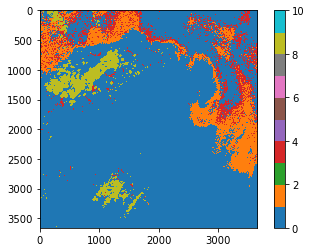

In [26]:
with rasterio.open(url) as ds:
    X = ds.read(1)
plt.imshow(X, vmax=10, cmap='tab10', interpolation='None')
plt.colorbar()